# San Francisco Rental Prices Dashboard

In this notebook, you will compile the visualizations from the previous analysis into functions that can be used for a Panel dashboard.

In [221]:
# imports
import panel as pn
pn.extension('plotly')
import plotly.express as px
import pandas as pd
import hvplot.pandas
import matplotlib.pyplot as plt
import os
from pathlib import Path
from dotenv import load_dotenv
%matplotlib inline 

In [222]:
# Read the Mapbox API key
load_dotenv()
map_box_api = os.getenv("mapbox")
px.set_mapbox_access_token(map_box_api)
#print(map_box_api)

# Import Data

In [223]:
# Import the necessary CSVs to Pandas DataFrames
file_path = Path("Data/sfo_neighborhoods_census_data.csv")
sfo_data = pd.read_csv(file_path, index_col="year")
#sfo_data.head()

file_path2 = Path("Data/neighborhoods_coordinates.csv")
location_data = pd.read_csv(file_path2)
#location_data.head()

#dataframe for top ten most expensive neighborhoods
expensive_df = sfo_data.groupby(['neighborhood']).mean().reset_index()
expensive_df = expensive_df.sort_values('sale_price_sqr_foot', ascending = False).reset_index()
expensive_df = expensive_df.iloc[0:10]
expensive_df.drop(columns=['index'], inplace=True) 

#dataframe for grouped by year and neighborhood
new_df = sfo_data.groupby(['year','neighborhood']).mean().reset_index()

#dataframe for mean value of each neighborhood
neighborhood_mean_df = sfo_data.groupby(['neighborhood']).mean().reset_index()

#concated dataframe for mapbox 
neighborhood_concat = pd.concat([location_data, neighborhood_mean_df], axis=1).dropna()
neighborhood_concat.drop(columns=['neighborhood'], inplace=True)

- - -

## Panel Visualizations

In this section, you will copy the code for each plot type from your analysis notebook and place it into separate functions that Panel can use to create panes for the dashboard. 

These functions will convert the plot object to a Panel pane.

Be sure to include any DataFrame transformation/manipulation code required along with the plotting code.

Return a Panel pane object from each function that can be used to build the dashboard.

Note: Remove any `.show()` lines from the code. We want to return the plots instead of showing them. The Panel dashboard will then display the plots.

In [246]:
# Define Panel Visualization Functions

#The notes from my rental analysis were mostly removed when I copy and pasted the code for these functions. 
#this was to keep these functions easier to edit without getting confused by the extra text. 

def housing_units_per_year():
        
    housing_units = (sfo_data['housing_units'].groupby(['year']).mean()) #could've put sfo_data.index
    housing_units = housing_units.astype(int)
    
    fig_housing_units = plt.figure()
    
    housing_units_bar = housing_units.plot(kind = 'bar', ylabel = 'Housing Units', xlabel = 'Year',
                   ylim = (housing_units.min()-housing_units.std(), housing_units.max()+housing_units.std()),
                   title = 'Housing Units in San Francisco from 2010 to 2016')
    
    plt.close(fig_housing_units)
    return  pn.pane.Matplotlib(fig_housing_units, tight=True)



def average_gross_rent():
    """Average Gross Rent in San Francisco Per Year."""
    
    housing_costs = (sfo_data[['sale_price_sqr_foot', 'gross_rent']].groupby(['year']).mean())
    housing_costs = housing_costs.astype({'gross_rent' : int})
    
    
    rent_plot = housing_costs.plot.line(y = 'gross_rent', color = 'red')
    rent_plot.set_xlabel('Year', fontsize = 12)
    rent_plot.set_ylabel('Gross Rent', fontsize = 12)
    rent_plot.set_title('Average Gross Rent by Year', fontsize = 14, fontweight='bold')
    rent_plot.set_xlim(2010,2016)
   
    
    return rent_plot


def average_sales_price():
    """Average Sales Price Per Year."""
    housing_costs = (sfo_data[['sale_price_sqr_foot', 'gross_rent']].groupby(['year']).mean())
    housing_costs = housing_costs.astype({'gross_rent' : int})
    
    
    
    sqft_plot = housing_costs.plot(kind = 'line', y = 'sale_price_sqr_foot',
                              title = 'Average Sales Price per SqFt by Year',
                              xlabel = 'Year', ylabel = 'Price per SqFt',
                              xlim = (2010,2016), color = 'purple')
    return sqft_plot



def average_price_by_neighborhood():
    """Average Prices by Neighborhood."""
    
    avgprice_hvplot = new_df.hvplot(x = 'year', y = 'sale_price_sqr_foot', groupby = 'neighborhood',
                               ylabel = 'Avg. Sale Price per Square Foot', xlabel = 'Year')
    
    
    return avgprice_hvplot #average price per sq ft
   

def average_monthly_rent_by_neighborhood(): #I created this function to show this plot    
    avg_monthly_rent_hvplot = new_df.hvplot(x = 'year', y = 'gross_rent', ylabel = 'Avg. Gross Rent Price per Year',
                                      xlabel = 'Year', groupby = 'neighborhood')
    
    
    return avg_monthly_rent_hvplot #average monthly rent



def top_most_expensive_neighborhoods():
    """Top 10 Most Expensive Neighborhoods."""
    top_ten_expensive_plot = expensive_df.hvplot.bar(x = 'neighborhood',
                                           y = 'sale_price_sqr_foot', title = 'Top 10 Expensive Neighborhoods in SFO',
                                           rot = 90, height = 500, xlabel = 'Neighborhood',
                                                 ylabel = 'Avg. Sale Price per Sqaure Foot')
    return top_ten_expensive_plot
   
    


def most_expensive_neighborhoods_rent_sales():
    """Comparison of Rent and Sales Prices of Most Expensive Neighborhoods."""   
    
    columns = ['sale_price_sqr_foot', 'gross_rent']
    comparison_barplot = new_df.hvplot.bar(groupby = 'neighborhood', y = columns, ylabel = 'Price',
                                      rot = 90, x = 'year', height = 500)

    return comparison_barplot

    
    
def parallel_coordinates():
    """Parallel Coordinates Plot."""

    parallel_coordinates_plot = px.parallel_coordinates(expensive_df, color = 'sale_price_sqr_foot', 
                        title = 'Parallel Coordinates Analysis of Most Expensive San Francsico Neighborhoods',
                       height = 500, width = 900)
    return parallel_coordinates_plot



def parallel_categories():
    """Parallel Categories Plot."""
    
    parallel__categories_plot = px.parallel_categories(
    expensive_df, #dataframe we created from the top 10 expensive neighborhoods to own
    dimensions=["neighborhood", "sale_price_sqr_foot", "housing_units", "gross_rent"], #these are the columns for plotted data
    color="sale_price_sqr_foot", 
    color_continuous_scale=px.colors.sequential.Inferno, #this was demo, changes color
    labels={
        "neighborhood": "Neighborhood",
        "sale_price_sqr_foot": "Sales price per Square Foot",
        "housing_units": "Housing Units",
        "gross_rent": "Gross Rent"
    },#relabels the dimiensions 
    title = 'Parallel Categories Analysis of Most Expensive San Francsico Neighborhoods',
    height = 500,
    width = 900)
    return parallel__categories_plot


def neighborhood_map():
    """Neighborhood Map."""

    mapbox_plot = px.scatter_mapbox(
    neighborhood_concat,
    lat="Lat",
    lon="Lon",
    color="gross_rent", 
    size="sale_price_sqr_foot",
    height = 500,
    zoom = 11,
    title = 'Average Sale Price per Square Foot and Gross Rent in San Francisco')
    
    return mapbox_plot


def sunburst():
    """Sunburst Plot."""
    df_expensive_neighborhoods_per_year = new_df[new_df["neighborhood"].isin(expensive_df["neighborhood"])]
    sunburst_plot = px.sunburst(df_expensive_neighborhoods_per_year, path=['year', 'neighborhood'],
                      values='sale_price_sqr_foot', color='gross_rent', height =700,
                      color_continuous_scale='Blues',
                     title = 'Cost Analysis of Most Expensive Neighborhoods in San Francsico per Year')
    return sunburst_plot


## Panel Dashboard

In this section, you will combine all of the plots into a single dashboard view using Panel. Be creative with your dashboard design!

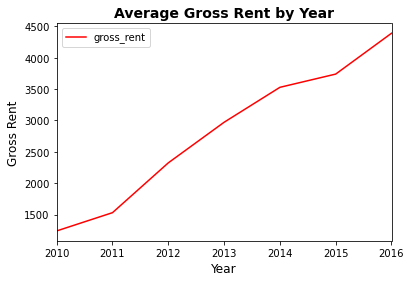

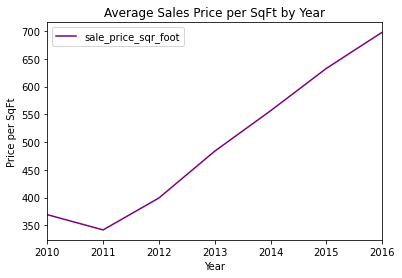

In [237]:
# Create a Title for the Dashboard
#source below helped me create this:
#https://medium.com/analytics-vidhya/how-to-create-an-interactive-dashboard-in-python-using-holoviz-panel-2de350b6d8df
dashboard_title = '# Real Estate Analysis of San Francisco from 2010 to 2016'
dashboard_description = "This is a place holder description"

# Create a tab layout for the dashboard
yearly_market_analysis = pn.Row(housing_units_per_year() ,average_gross_rent(),average_sales_price())

neighborhood_monlthy_analysis = pn.Column(dashboard_title, average_price_by_neighborhood(), average_monthly_rent_by_neighborhood())

expensive_neighborhood_analysis = pn.Column(dashboard_title,
                                            top_most_expensive_neighborhoods(), most_expensive_neighborhoods_rent_sales())

parallelplot_anaysis = pn.Column(dashboard_title, parallel_categories(), parallel_coordinates())

neighborhood_tab = pn.Column(dashboard_title, dashboard_description,neighborhood_map())

sunburst_tab = pn.Column(dashboard_title,sunburst())


# Create the dashboard
dashboard = pn.Tabs(
    ("Welcome",neighborhood_tab), 
    ("Yearly Market Analysis",yearly_market_analysis),
    ("Monthly Neighborhood Analysis",neighborhood_monlthy_analysis),
    ("Expensive Neighborhood Analysis",expensive_neighborhood_analysis),
    ("Parallel Plots Analysis",parallelplot_anaysis),
    ("Sunburst Analysis",sunburst_tab)
)

## Serve the Panel Dashboard

In [239]:
# Serve the# dashboard
#dashboard.servable()

# Debugging

Note: Some of the Plotly express plots may not render in the notebook through the panel functions.

However, you can test each plot by uncommenting the following code

Matplotlib(Figure, tight=True)
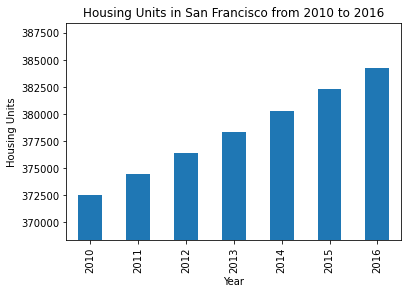

In [215]:
housing_units_per_year()

<AxesSubplot:title={'center':'Average Gross Rent by Year'}, xlabel='Year', ylabel='Gross Rent'>

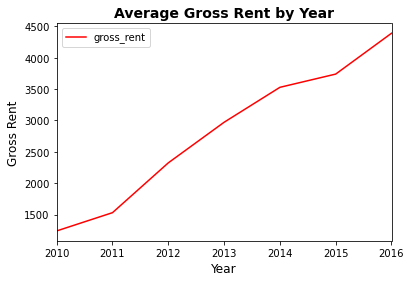

In [240]:
average_gross_rent()

<AxesSubplot:title={'center':'Average Sales Price per SqFt by Year'}, xlabel='Year', ylabel='Price per SqFt'>

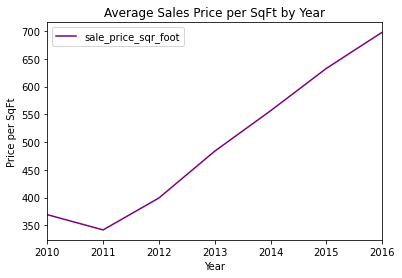

In [241]:
average_sales_price()

In [245]:
# average_price_by_neighborhood()

In [244]:
#top_most_expensive_neighborhoods()

In [243]:
#most_expensive_neighborhoods_rent_sales()

In [113]:
# neighborhood_map().show()

In [79]:
# parallel_categories()

In [80]:
 #parallel_coordinates()

In [81]:
#sunburst()